In [10]:
import pandas as pd
import numpy as np

import googleapiclient.discovery       # the google api to get data
import googleapiclient.errors
from textblob import TextBlob
import csv

import nltk            # Natural Language Toolkit for tokenization
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

from scipy import stats

import matplotlib.pyplot as plt    # for visualization
from wordcloud import WordCloud
import seaborn as sns

import joblib          # for saving ML model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_all_comments(video_id):
    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = 'process.env.DEVELOPER_KEY'  # Replace with your actual API key

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    # Initial request to get comments
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100
    )
    response = request.execute()

    comments = []

    # Add comments from the initial request
    for item in response['items']:
        comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comments.append(comment_text)

        reply_request = youtube.comments().list(
            part="snippet",
            parentId=item['id']
        )
        reply_response = reply_request.execute()

        # Add replies to the comments list
        for reply_item in reply_response['items']:
            reply_text = reply_item['snippet']['textDisplay']
            comments.append(reply_text)

    # Paginate through additional comments if available
    while 'nextPageToken' in response:
        nextPageToken = response['nextPageToken']
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=nextPageToken
        )
        response = request.execute()

        # Add comments from the paginated request
        for item in response['items']:
            comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment_text)

            reply_request = youtube.comments().list(
                part="snippet",
                parentId=item['id']
            )
            reply_response = reply_request.execute()

            # Add replies to the comments list
            for reply_item in reply_response['items']:
                reply_text = reply_item['snippet']['textDisplay']
                comments.append(reply_text)

    return comments

video_id = 'id_MB2RClG4'     # Any YouTube video id
all_comments = get_all_comments(video_id)

In [12]:
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    sentiment = analysis.sentiment.polarity

    if sentiment > 0:
        label = 'Yes'
    else:
        label = 'No'

    return label

In [13]:
def save_to_csv(comments, csv_file_name='youtube_comments.csv'):
    labels = []

    for comment_text in comments:
        label = analyze_sentiment(comment_text)
        labels.append(label)

    data = {'Comments': comments, 'Classes': labels}
    df = pd.DataFrame(data)
    df.to_csv(csv_file_name, index=False, encoding='utf-8')
    print(f'Data has been saved to {csv_file_name}')


save_to_csv(all_comments)

Data has been saved to youtube_comments.csv


In [14]:
df = pd.read_csv("./youtube_comments.csv")
print("There are", df["Comments"].count(), "comments in a dataset.")

There are 7268 comments in a dataset.


In [15]:
print("Shape of the dataset is:", df.shape)

Shape of the dataset is: (7268, 2)


In [16]:
print("Showing top 8 comments of a dataset using head")
df.head(8)

Showing top 8 comments of a dataset using head


,Comments,Classes
0,Congratulations Khan sir<br>Thank you Elon mus...,No
1,Congratulations sir 🎉🎉 <br>For transforming on...,Yes
2,Thank you man ! ❤,No
3,🤝,No
4,Thanks Elon ❤,Yes
5,"Funnily enough, it is from Khan Academy that I...",No
6,"Thank you, Elon, for your generous donation ❤️",No
7,Elon Musk is a Genius,No


In [17]:
print("Showing last 8 comments of a dataset using tail")
df.tail(8)

Showing last 8 comments of a dataset using tail


,Comments,Classes
7260,:),Yes
7261,Hi.......,No
7262,🙌🏽,No
7263,Oop,No
7264,❤❤❤❤,No
7265,first,Yes
7266,@CharleyCheno Yes!!,No
7267,@JewelBelleLove Yes!!,No


In [18]:
null_values = df["Comments"].isnull().sum()
print("There are" , null_values, "null values in Comments.")

There are 0 null values in Comments.


In [19]:
unique_values = df['Comments'].unique()
print("There are total", len(unique_values), "unique values before data pre-processing.")

There are total 7007 unique values before data pre-processing.


In [20]:
print("The type of dataset is:")
df.dtypes

The type of dataset is:


,0
Comments,object
Classes,object


In [21]:
print("This describes you the statistical summary of a dataset:\n")
df.describe()

This describes you the statistical summary of a dataset:



,Comments,Classes
count,7268,7268
unique,7007,2
top,Nice,No
freq,16,3706


In [22]:
print("This describes you the metadata of a dataset:")
df.info()

This describes you the metadata of a dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7268 entries, 0 to 7267
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  7268 non-null   object
 1   Classes   7268 non-null   object
dtypes: object(2)
memory usage: 113.7+ KB


In [23]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Replace the sample data with your actual data
comments_rows = df["Comments"]

classes_rows = df["Classes"]

# Create a DataFrame using your actual data
data = {'comments': comments_rows, 'classes': classes_rows}
df = pd.DataFrame(data)

# Apply text cleaning to the "comments" column in the DataFrame
df['comments'] = df['comments'].apply(clean_text)

# Print the cleaned DataFrame
print("After converting rows and columns into lowercase\n", df)

After converting rows and columns into lowercase
                                                comments classes
0     congratulations khan sirbrthank you elon musk sir      No
1     congratulations sir brfor transforming online ...     Yes
2                                         thank you man      No
3                                                            No
4                                           thanks elon     Yes
...                                                 ...     ...
7263                                                oop      No
7264                                                         No
7265                                              first     Yes
7266                                   charleycheno yes      No
7267                                 jewelbellelove yes      No

[7268 rows x 2 columns]


In [24]:
# Get the list of English stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Replace the sample data with your actual data
data = {'comments': df["comments"], 'classes': df["classes"]}

# Create a DataFrame using your actual data
df = pd.DataFrame(data)

# Apply stop word removal to the "comments" column in the DataFrame
df['comments'] = df['comments'].apply(remove_stopwords)

# Print the DataFrame with stop words removed
print("After handling stopwords\n", df)

After handling stopwords
                                                comments classes
0         congratulations khan sirbrthank elon musk sir      No
1     congratulations sir brfor transforming online ...     Yes
2                                             thank man      No
3                                                            No
4                                           thanks elon     Yes
...                                                 ...     ...
7263                                                oop      No
7264                                                         No
7265                                              first     Yes
7266                                   charleycheno yes      No
7267                                 jewelbellelove yes      No

[7268 rows x 2 columns]


In [25]:
data = {
    'comments': df["comments"],
    'classes': df["classes"]
}

df = pd.DataFrame(data)

# Count the number of duplicate values before removing
duplicate_comments_sum = df.duplicated(subset='comments').sum()

# Create a Series of boolean values indicating duplicate comments
original_duplicates = df.duplicated(subset='comments')

# Extract the duplicate comments using the boolean mask
duplicate_comments = df.loc[original_duplicates, 'comments']

# CSV file in which only duplicates comments
duplicate_comments.to_csv('duplicates_comments.csv', index=False)

# Print
print("Duplicate Comments:", duplicate_comments_sum)
print("Duplicated Comments are below:\n", duplicate_comments)

Duplicate Comments: 845
Duplicated Comments are below:
 54                     
75                     
76      love bangladesh
103                    
108                 wow
             ...       
7260                   
7261                 hi
7262                   
7264                   
7265              first
Name: comments, Length: 845, dtype: object


In [26]:

# Remove duplicates from column 'comments' and keep the first occurrence
df = df.drop_duplicates(subset='comments', keep='first')

# Count the number of duplicate values after removing
removed_duplicates_count = duplicate_comments_sum - df.duplicated(subset='comments').sum()

print("Number of Duplicated Comments Removed:", removed_duplicates_count)

Number of Duplicated Comments Removed: 845


In [27]:
print("There are", df["comments"].count(), "comments in a dataset after data pre-processing.")

There are 6423 comments in a dataset after data pre-processing.


In [28]:
df.describe()

,comments,classes
count,6423,6423
unique,6423,2
top,jewelbellelove yes,Yes
freq,1,3236


In [29]:
print("Shape of the dataset is:", df.shape)

Shape of the dataset is: (6423, 2)


In [30]:
data = {
    'comments': df['comments'],
    'classes': df['classes']
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation of the Z-Scores
mean = np.mean(df['comments'].str.len())
std_dev = np.std(df['comments'].str.len())

# Calculate Z-Scores for each data point
df['z_scores'] = (df['comments'].str.len() - mean) / std_dev

# Define a threshold for identifying outliers
threshold = 2

# Identify outliers based on the threshold
outliers = df[df['z_scores'].abs() > threshold]

# Print the Z-Scores and outliers
print("Z-Scores:\n", df[['comments', 'z_scores']])
print("\nThere are", len(outliers[['comments', 'z_scores']]), "Outliers detected.")
print("\nOutliers:\n", outliers[['comments', 'z_scores']])


Z-Scores:
                                                comments  z_scores
0         congratulations khan sirbrthank elon musk sir -0.107027
1     congratulations sir brfor transforming online ...  4.118819
2                                             thank man -0.698974
3                                                       -0.846961
4                                           thanks elon -0.666088
...                                                 ...       ...
7258                            first view like comment -0.468772
7259                                       sal type gal -0.649645
7263                                                oop -0.797632
7266                                   charleycheno yes -0.583873
7267                                 jewelbellelove yes -0.550987

[6423 rows x 2 columns]

There are 210 Outliers detected.

Outliers:
                                                comments  z_scores
1     congratulations sir brfor transforming online ...  4.1

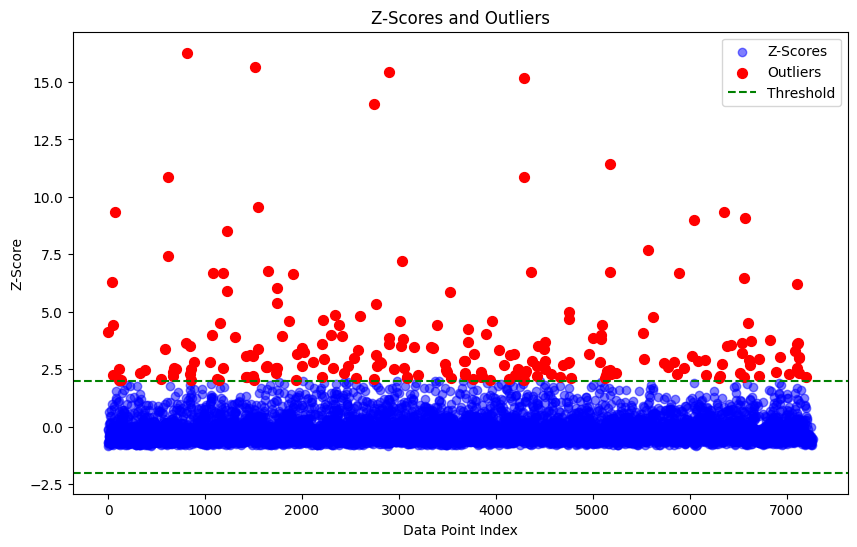

In [31]:
# Create a scatter plot to visualize the Z-scores and outliers
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['z_scores'], color = 'blue', label = 'Z-Scores', alpha = 0.5)
plt.scatter(outliers.index, outliers['z_scores'], color = 'red', label = 'Outliers', marker = 'o', s = 50)
plt.axhline(y = threshold, color = 'green', linestyle = '--', label = 'Threshold')
plt.axhline(y = -threshold, color = 'green', linestyle = '--')
plt.legend()
plt.title('Z-Scores and Outliers')
plt.xlabel('Data Point Index')
plt.ylabel('Z-Score')
plt.show()

In [32]:
# Before removing outliers
original_size = len(df)

# After removing outliers
df = df[df['z_scores'].abs() <= threshold]
cleaned_size = len(df)

print("Original DataFrame size:", original_size)
print("Cleaned DataFrame size (without outliers):", cleaned_size)

Original DataFrame size: 6423
Cleaned DataFrame size (without outliers): 6213


In [33]:
# Remove outliers from the DataFrame
df_no_outliers = df[df['z_scores'].abs() <= threshold]

# Print the Z-Scores and outliers
print("Z-Scores:\n", df[['comments', 'z_scores']])
print("\nThere are", len(outliers[['comments', 'z_scores']]), "Outliers detected.")
print("\nOutliers:\n", outliers[['comments', 'z_scores']])

Z-Scores:
                                            comments  z_scores
0     congratulations khan sirbrthank elon musk sir -0.107027
2                                         thank man -0.698974
3                                                   -0.846961
4                                       thanks elon -0.666088
5       funnily enough khan academy found elon musk -0.139913
...                                             ...       ...
7258                        first view like comment -0.468772
7259                                   sal type gal -0.649645
7263                                            oop -0.797632
7266                               charleycheno yes -0.583873
7267                             jewelbellelove yes -0.550987

[6213 rows x 2 columns]

There are 210 Outliers detected.

Outliers:
                                                comments  z_scores
1     congratulations sir brfor transforming online ...  4.118819
37    years old studying english writers f

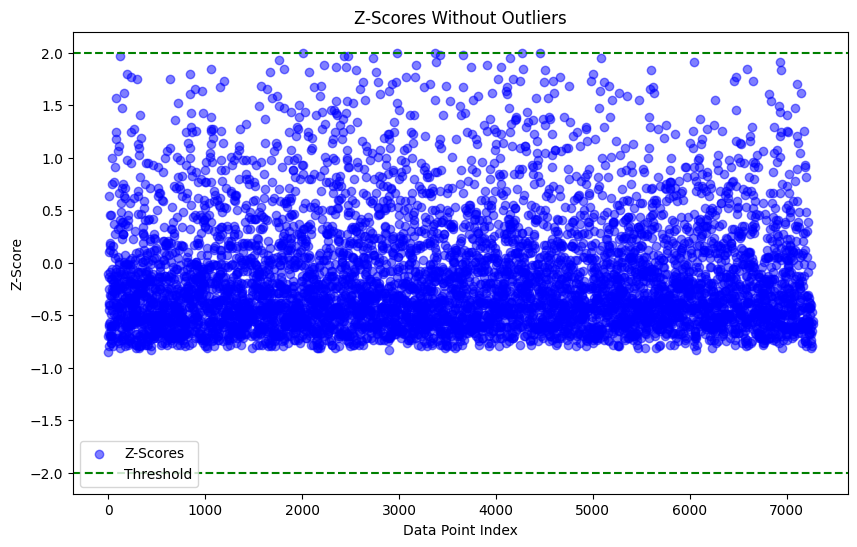

In [34]:
# Create a scatter plot to visualize the Z-scores without outliers
plt.figure(figsize=(10, 6))
plt.scatter(df_no_outliers.index, df_no_outliers['z_scores'], color='blue', label='Z-Scores', alpha=0.5)
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.axhline(y=-threshold, color='green', linestyle='--')
plt.legend()
plt.title('Z-Scores Without Outliers')
plt.xlabel('Data Point Index')
plt.ylabel('Z-Score')
plt.show()

In [35]:
X = df['comments']
y = df['classes']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42)

In [36]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [37]:
# for Naïve Bayes
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the classifier
naive_bayes_classifier = MultinomialNB()

# Train the classifier on the TF-IDF transformed data
naive_bayes_classifier.fit(X_train_tfidf, y_train)

# Save the Naïve Bayes model
joblib.dump(naive_bayes_classifier, 'naive_bayes_model.joblib')

['naive_bayes_model.joblib']

In [38]:
from sklearn.metrics import classification_report as classification_report_naivebayes

# Load the Naïve Bayes model
loaded_naive_bayes_classifier = joblib.load('naive_bayes_model.joblib')

# Make predictions on the test data using the loaded model
y_pred = loaded_naive_bayes_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
naivebayes_accuracy = accuracy_score(y_test, y_pred)
nb_classification_report_str = classification_report_naivebayes(y_test, y_pred)

# Print the results
print("Accuracy:", naivebayes_accuracy)
print("Classification Report:\n", nb_classification_report_str)

Accuracy: 0.7655172413793103
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.62      0.73      1124
         Yes       0.70      0.92      0.79      1051

    accuracy                           0.77      2175
   macro avg       0.79      0.77      0.76      2175
weighted avg       0.80      0.77      0.76      2175



Confusion Matrix (Naïve Bayes):
 [[702 422]
 [ 88 963]]


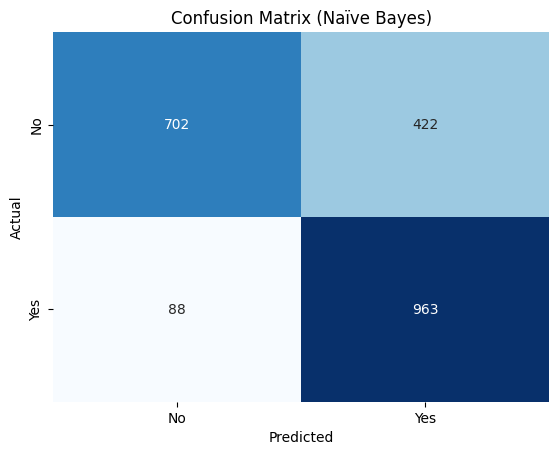

In [39]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Random Forest Tree
conf_matrix_nb = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (Naïve Bayes):\n", conf_matrix_nb)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_naive_bayes_classifier.classes_,
            yticklabels=loaded_naive_bayes_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naïve Bayes)')
plt.show()

In [40]:
# for Naïve Bayes Multinomial
from sklearn.naive_bayes import MultinomialNB

# Create an instance of the classifier
nb_classifier = MultinomialNB()

# Train the classifier on the TF-IDF transformed data
nb_classifier.fit(X_train_tfidf, y_train)

# Save the Naïve Bayes model
joblib.dump(nb_classifier, 'naive_bayes_multinomial_model.joblib')

['naive_bayes_multinomial_model.joblib']

In [41]:
from sklearn.metrics import classification_report as classification_report_nbmn

# Load the Naïve Bayes Multinomial model
loaded_nb_classifier = joblib.load('naive_bayes_multinomial_model.joblib')

# Make predictions on the test data
y_pred_nbmn = loaded_nb_classifier.predict(X_test_tfidf)

# Model evaluation
accuracy_nbmn = accuracy_score(y_test, y_pred_nbmn)
nbm_classification_report_str = classification_report_nbmn(y_test, y_pred_nbmn)

print("Accuracy:", accuracy_nbmn)
print("Classification Report:\n", nbm_classification_report_str)

Accuracy: 0.7655172413793103
Classification Report:
               precision    recall  f1-score   support

          No       0.89      0.62      0.73      1124
         Yes       0.70      0.92      0.79      1051

    accuracy                           0.77      2175
   macro avg       0.79      0.77      0.76      2175
weighted avg       0.80      0.77      0.76      2175



Confusion Matrix (Naïve Bayes Multinomial):
 [[702 422]
 [ 88 963]]


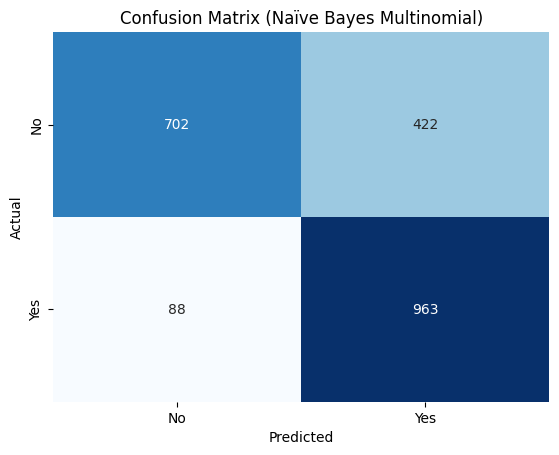

In [42]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for Naïve Bayes Multinomial
conf_matrix_nbmn = confusion_matrix(y_test, y_pred_nbmn)

print("Confusion Matrix (Naïve Bayes Multinomial):\n", conf_matrix_nbmn)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_nbmn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_nb_classifier.classes_,
            yticklabels=loaded_nb_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naïve Bayes Multinomial)')
plt.show()

In [43]:
# for Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state = 42)

decision_tree_classifier.fit(X_train_tfidf, y_train)

# Save the Decision Tree model
joblib.dump(decision_tree_classifier, 'decision_tree_model.joblib')

['decision_tree_model.joblib']

In [44]:
from sklearn.metrics import classification_report as classification_report_decisiontree

# Load the Decision Tree model
loaded_decision_tree_classifier = joblib.load('decision_tree_model.joblib')

# Make predictions on the test data
y_pred_decisiontree = loaded_decision_tree_classifier.predict(X_test_tfidf)

# Evaluate the model's performance
decisiontree_accuracy = accuracy_score(y_test, y_pred_decisiontree)
decision_classification_report_str = classification_report_decisiontree(y_test, y_pred_decisiontree)

print("Accuracy:", decisiontree_accuracy)
print("Classification Report:\n", decision_classification_report_str)

Accuracy: 0.8841379310344828
Classification Report:
               precision    recall  f1-score   support

          No       0.88      0.89      0.89      1124
         Yes       0.88      0.88      0.88      1051

    accuracy                           0.88      2175
   macro avg       0.88      0.88      0.88      2175
weighted avg       0.88      0.88      0.88      2175



Confusion Matrix (Decision Tree):
 [[1003  121]
 [ 131  920]]


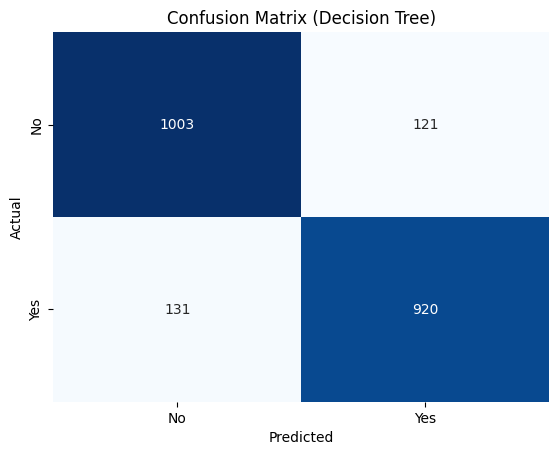

In [45]:
# Confusion matrix for Decision Tree
conf_matrix_decisiontree = confusion_matrix(y_test, y_pred_decisiontree)

print("Confusion Matrix (Decision Tree):\n", conf_matrix_decisiontree)

# Visualize the confusion matrix using a heatmap
sns.heatmap(conf_matrix_decisiontree, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_decision_tree_classifier.classes_,
            yticklabels=loaded_decision_tree_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

In [46]:
# for Random Forest Tree
from sklearn.ensemble import RandomForestClassifier  # for classification

# Create and train the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_model.fit(X_train_tfidf, y_train)

# Save the Decision Tree model
joblib.dump(random_forest_model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [47]:
from sklearn.metrics import classification_report as classification_report_ramdonforest

# Create and train the Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')

# Load the Random Forest model
loaded_random_forest_model = joblib.load('random_forest_model.joblib')

# Make predictions on the test data
y_pred_randomforest = loaded_random_forest_model.predict(X_test_tfidf)

# Evaluate the model's performance
randomforest_accuracy = accuracy_score(y_test, y_pred_randomforest)
random_classification_report_str = classification_report_ramdonforest(y_test, y_pred_randomforest)

print("Accuracy:", randomforest_accuracy)
print("Classification Report:\n", random_classification_report_str)

Accuracy: 0.8891954022988505
Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.93      0.90      1124
         Yes       0.92      0.84      0.88      1051

    accuracy                           0.89      2175
   macro avg       0.89      0.89      0.89      2175
weighted avg       0.89      0.89      0.89      2175



Confusion Matrix (Random Forest Tree):
 [[1048   76]
 [ 165  886]]


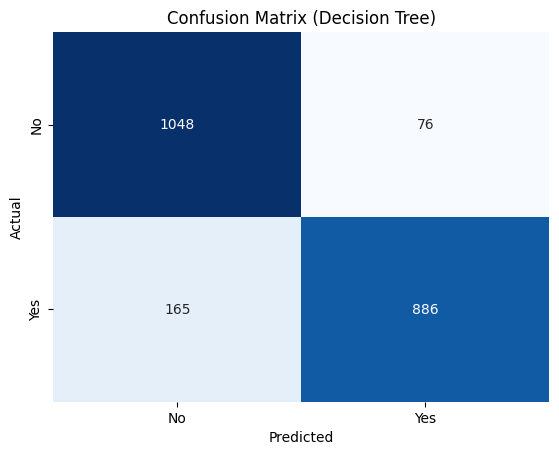

In [48]:
# Confusion matrix for Random Forest Tree
conf_matrix_randomforest = confusion_matrix(y_test, y_pred_randomforest)

print("Confusion Matrix (Random Forest Tree):\n", conf_matrix_randomforest)

sns.heatmap(conf_matrix_randomforest, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=loaded_random_forest_model.classes_,
            yticklabels=loaded_random_forest_model.classes_)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

In [49]:
result_data = {
    'ML Model': ['Naïve Bayes', 'Naïve Bayes Multinomial', 'Decision Tree', 'Random Forest Tree'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
}

def extract_metrics(accuracy_value, report_str):
    accuracy = accuracy_value
    lines = report_str.split('\n')
    precision, recall, f1_score = map(float, lines[2].split()[1:4])
    return [accuracy, precision, recall, f1_score]

# Naive Bayes Metrics
accuracy_nb, precision_nb, recall_nb, f1_score_nb = extract_metrics(naivebayes_accuracy, nb_classification_report_str)
result_data['Accuracy'].append(naivebayes_accuracy)
result_data['Precision'].append(precision_nb)
result_data['Recall'].append(recall_nb)
result_data['F1-Score'].append(f1_score_nb)

# Naive Bayes Multinomial Metrics
accuracy_nbmn, precision_nbmn, recall_nbmn, f1_score_nbmn = extract_metrics(accuracy_nbmn, nbm_classification_report_str)
result_data['Accuracy'].append(accuracy_nbmn)
result_data['Precision'].append(precision_nbmn)
result_data['Recall'].append(recall_nbmn)
result_data['F1-Score'].append(f1_score_nbmn)

# Decision Tree Metrics
accuracy_decisiontree, precision_decisiontree, recall_decisiontree, f1_score_decisiontree = extract_metrics(decisiontree_accuracy, decision_classification_report_str)
result_data['Accuracy'].append(accuracy_decisiontree)
result_data['Precision'].append(precision_decisiontree)
result_data['Recall'].append(recall_decisiontree)
result_data['F1-Score'].append(f1_score_decisiontree)

# Random Forest Metrics
accuracy_randomforest, precision_randomforest, recall_randomforest, f1_score_randomforest = extract_metrics(randomforest_accuracy, random_classification_report_str)
result_data['Accuracy'].append(accuracy_randomforest)
result_data['Precision'].append(precision_randomforest)
result_data['Recall'].append(recall_randomforest)
result_data['F1-Score'].append(f1_score_randomforest)

data = pd.DataFrame(result_data)
print(data)

                  ML Model  Accuracy  Precision  Recall  F1-Score
0              Naïve Bayes  0.765517       0.89    0.62      0.73
1  Naïve Bayes Multinomial  0.765517       0.89    0.62      0.73
2            Decision Tree  0.884138       0.88    0.89      0.89
3       Random Forest Tree  0.889195       0.86    0.93      0.90


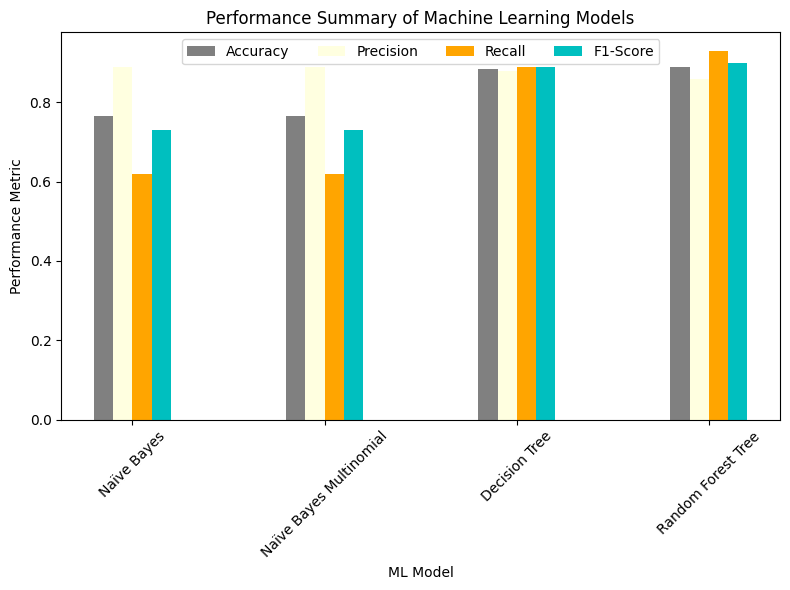

In [50]:
plt.figure(figsize=(8, 6))
plt.xlabel('ML Model')
plt.ylabel('Performance Metric')

# Create a bar chart
bar_width = 0.1
index = np.arange(len(data['ML Model']))

plt.bar(index, data['Accuracy'], bar_width, label='Accuracy', color='grey')
plt.bar(index + bar_width, data['Precision'], bar_width, label='Precision', color='lightyellow')
plt.bar(index + bar_width * 2, data['Recall'], bar_width, label='Recall', color='orange')
plt.bar(index + bar_width * 3, data['F1-Score'], bar_width, label='F1-Score', color='c')

plt.xticks(index + bar_width * 1.5, data['ML Model'])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4)
plt.title('Performance Summary of Machine Learning Models')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()